# MTE 544 Report

|Stephen Wang|Ajit Rakhra|Howard Dong|
|:-:|:-:|:-:|
|x2274wan|a3rakhra|h53dong|

Station 2, Robot 7 on Fri Sept 29 at 8:30 AM

In [1]:
%config InlineBackend.figure_formats = ["svg"]

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import re

We have produced the following trajectory paths by logging the `/odom` topic containing `nav_msgs/msg/Odometry`, which contained the estimated robot position; acceleration was measured on `/imu` that contained `sensor_msgs/msg/Imu`; laser scan was obtained on `/scan` that contained `sensor_msgs/msg/LaserScan`.

In [99]:
def get_data(name, parse=True):
    with open(name) as f:
        f.readline()
        data = f.read()
    if parse:
        return np.fromstring(data, sep=", ")
    else:
        return data

In [128]:
motion = "Line"
name = motion.lower()

def make_graph(motion):
    name = motion.lower()
    odom = get_data(f"odom_content_{name}.csv").reshape(-1, 4)
    imu = get_data(f"imu_content_{name}.csv").reshape(-1, 4)
    laser = get_data(f"laser_content_{name}.csv", parse=False).split("\n")[5]
    
    fig, axes = plt.subplots(1,3, figsize=(11,2))
    a = axes[0]
    a.set_title(f"{motion} Trajectory")
    a.set_xlabel("x")
    a.set_ylabel("y")
    a.grid()
    a.plot(odom[:,0], odom[:,1])
    a.axis("scaled")
    
    a = axes[1]
    a.set_title(f"{motion} IMU")
    a.set_xlabel("t")
    a.set_ylabel(r"$m/s^2$")
    a.grid()
    for i in range(3):
        a.plot(imu[:,3] - imu[0,3], imu[:,i])
    a.legend([r"$a_x$", r"$a_y$", r"value"])
    
    a = axes[2]
    a.set_title(f"{motion} Laser Scan")
    a.set_xlabel("x")
    a.set_ylabel("y")
    a.grid()
    angles = np.arange(720) / 720 * 2*np.pi
    ranges = re.match(r"^array\(\'f\'\, \[(.*)\]", data[1]).group(1)
    ranges = np.fromstring(ranges, sep=", ")
    a.plot(
        ranges*np.cos(angles), ranges*np.sin(angles),
        linestyle="None", markersize=1, marker="o")
    a.axis("scaled")

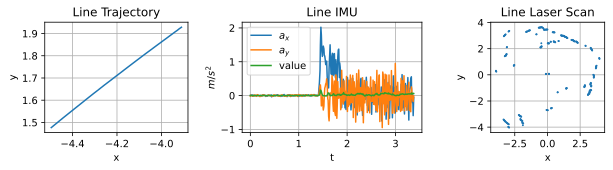

In [129]:
make_graph("Line")

<i><p style="text-align: center">Figure 1: The robot was given the input $u=[1\ 0]^\intercal$</p></i>

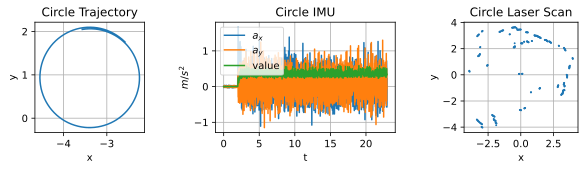

In [130]:
make_graph("Circle")

<p style="text-align: center">Figure 2: The robot was given the input $u=[1\ 1]^\intercal$</p>

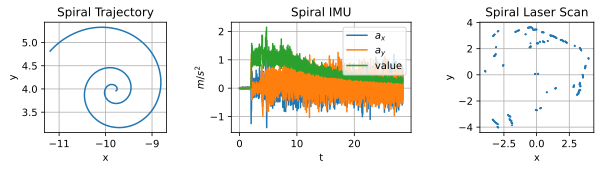

In [131]:
make_graph("Spiral")

<p style="text-align: center">Figure 3: The robot was given the input $u=[1\ \ 0.05t]^\intercal$</p>

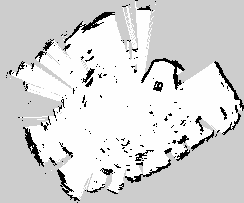

In [27]:
img_pil = PIL.Image.open("map.pgm")

img_pil

<i><p style="text-align: center;">Figure 4: The greyscale SLAM map of the obstacle course in the room</p></i>

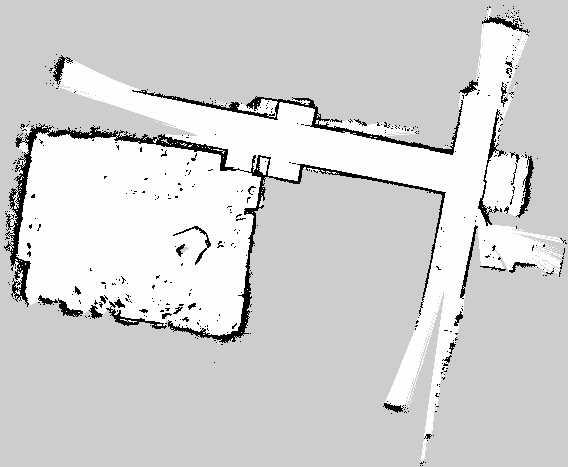

In [26]:
PIL.Image.open("corridor.pgm")

<i><p style="text-align: center;">Figure 5: Greyscale SLAM map of the lab corridor</p></i>